In [ ]:
!pip3 install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [2]:
import urllib

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from PIL import Image
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

### Load Model

In [3]:
device=torch.device( "cuda" if (torch.cuda.is_available()) else 'cpu')
device

device(type='cuda')

In [4]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=True).eval()
#model = model.to(device).eval()

Using cache found in C:\Users\Alok Suresh/.cache\torch\hub\pytorch_vision_v0.10.0


### Load raw images

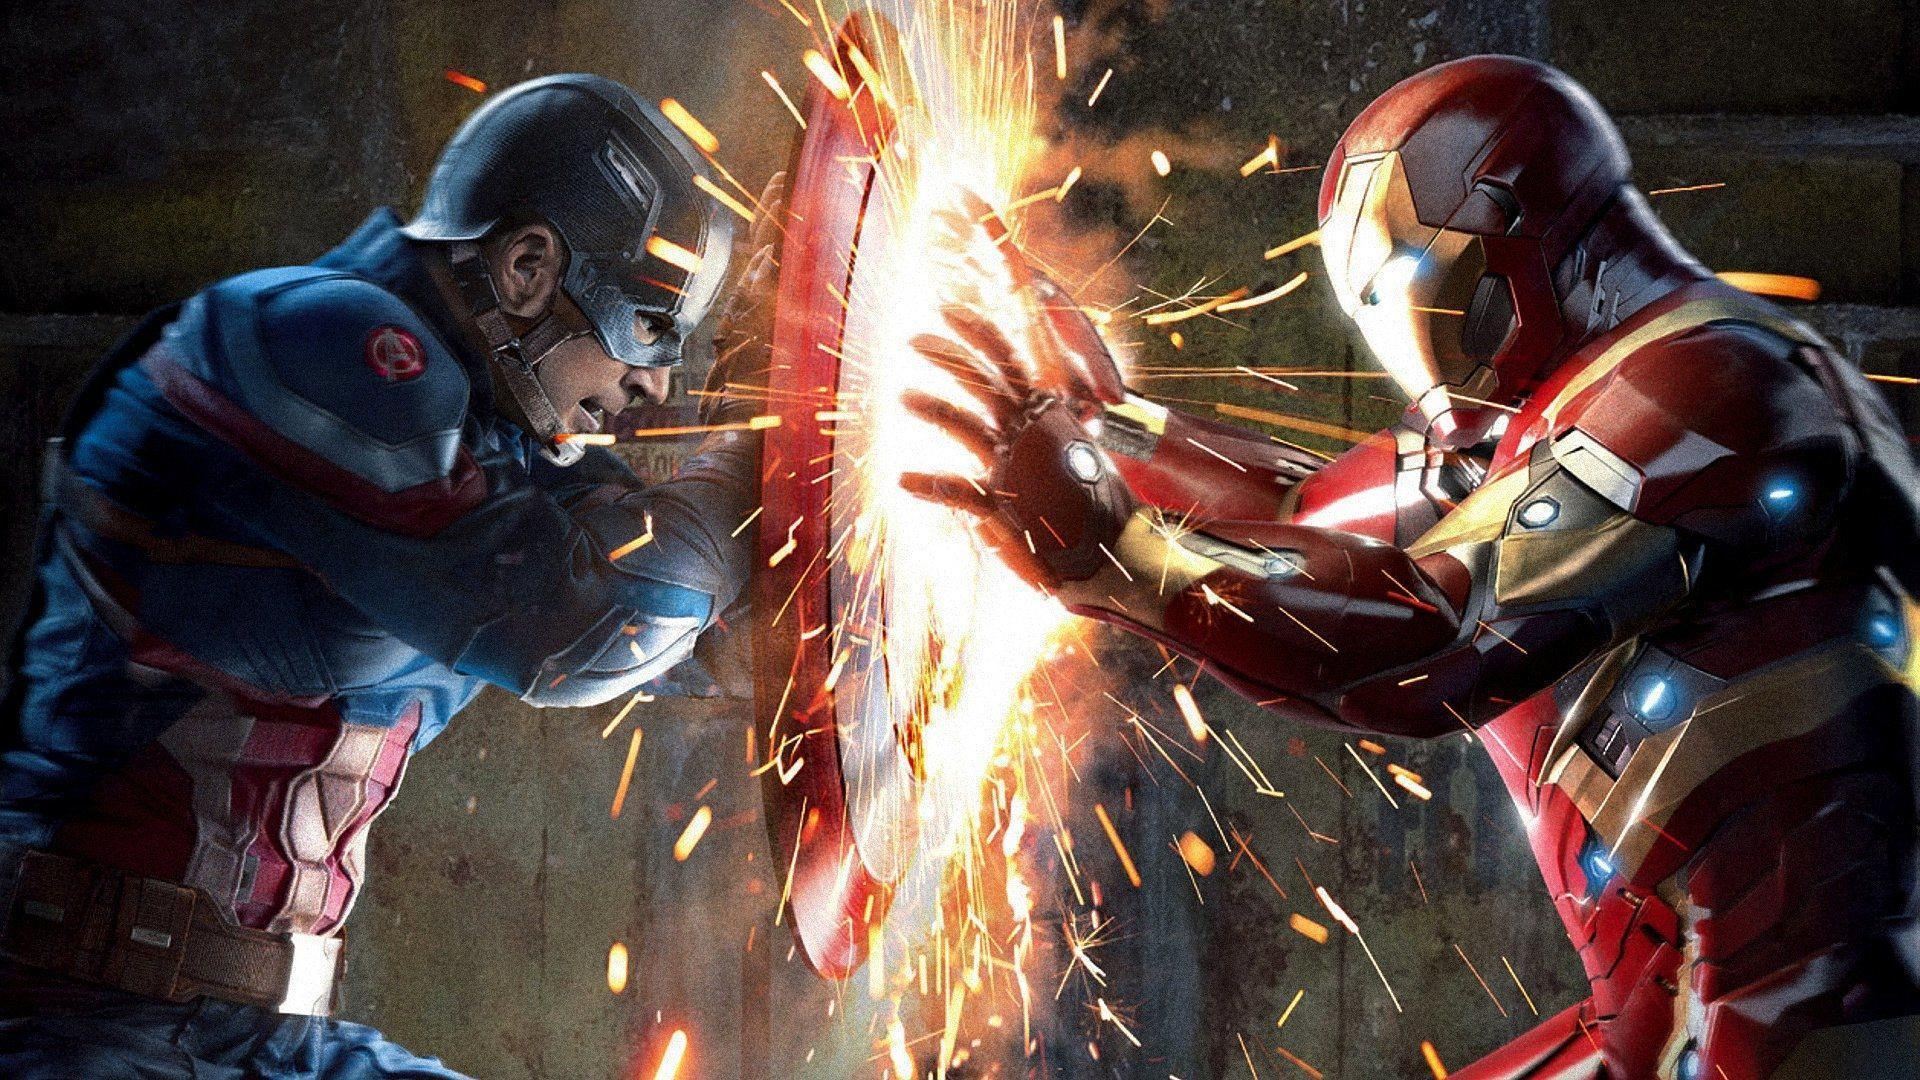

In [5]:
input_image = Image.open(r'C:\Users\Alok Suresh\Desktop\PersonalProjects\StyleTransfer\images\iron_man_fight.jfif')
input_image

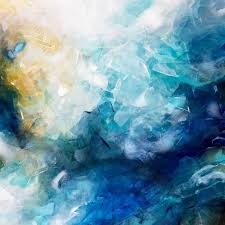

In [6]:
style_image_raw = Image.open(r'C:\Users\Alok Suresh\Desktop\PersonalProjects\StyleTransfer\images\style4.jfif')
style_image_raw

### Prepare content, style & generated images

In [7]:
def init_generated_img(tensor_shape): 
    return torch.rand(tensor_shape)      

to_pil = transforms.ToPILImage()

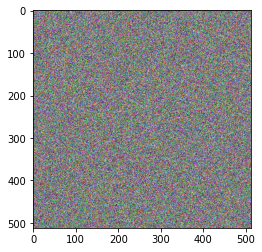

In [8]:
generated_image = init_generated_img((3, 512, 512))
plt.imshow(to_pil(generated_image).convert("RGB"))

In [68]:
process2 = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

content_image = process2(input_image)
content_image.size()

torch.Size([3, 512, 512])

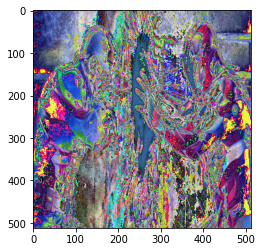

In [70]:
plt.imshow(to_pil(content_image).convert("RGB"))

In [74]:
style_image = process2(style_image_raw)
style_image.size()

torch.Size([3, 512, 512])

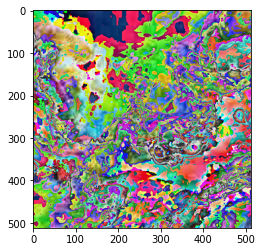

In [75]:
plt.imshow(to_pil(style_image).convert("RGB"))

In [76]:
# content_image = content_image.to(device, torch.float)
# style_image = style_image.to(device, torch.float)
# generated_image = generated_image.to(device, torch.float)

### Define cost functions

In [77]:
def content_cost_function(content_img_act, gen_img_act):
    return 0.5*squared_error(gen_img_act, content_img_act)

In [103]:
def style_cost_function(layer_activations):
    total_style_loss = 0
    layer_weights = [1.0, 0.8, 0.25, 0.25, 0.25]

    for idx, (layer, activations) in enumerate(layer_activations.items()):
        layer_style_loss = layer_weights[idx]*get_layer_style_loss(
            activations["style"], activations["gen"]
        )

        total_style_loss += layer_style_loss 
    
    return total_style_loss

def get_layer_style_loss(style_layer_activations, gen_layer_activations):
    scaling_constant = 1/(4*(style_layer_activations.size()[0]**2)*(style_layer_activations.size()[1]**2))
    style_gram_matrix = gram_matrix(style_layer_activations)
    gen_gram_matrix = gram_matrix(gen_layer_activations)

    return scaling_constant*squared_error(gen_gram_matrix, style_gram_matrix)

def gram_matrix(layer_activations): 
    return torch.mm(layer_activations, torch.transpose(layer_activations, 0 ,1))

def squared_error(preds, target): 
    return torch.sum(
        torch.square(preds - target)
    )


In [111]:
def style_transfer_cost_function(layer_activations, content_loss_layer=19):
    content_loss = content_cost_function(
        layer_activations[content_loss_layer]["content"],
        layer_activations[content_loss_layer]["gen"]
    )
    style_loss = style_cost_function(layer_activations)
    
    
    return 1e-2*content_loss + 1e9*style_loss

### Test cost functions

In [112]:
def construct_layer_activations(extraction_layers, gen_image):
    layer_activations = {}
    for layer in extraction_layers: 
        current_layer_activations = {
            "content": get_vgg_features(content_image, layer),
            "style": get_vgg_features(style_image, layer),
            "gen": get_vgg_features(gen_image, layer)
        }
        
        layer_activations[layer] = current_layer_activations
        
    return layer_activations
    
def get_vgg_features(input_tensor, extraction_layer): 
    input_batch = input_tensor.unsqueeze(0)
    
    output = model.features[:extraction_layer](input_batch).squeeze()
    
    return torch.reshape(output, (output.size()[0], output.size()[1]**2))

In [113]:
extraction_layers = [0, 5, 10, 19, 28]

In [114]:
test_layer_activations = construct_layer_activations(
    extraction_layers,
    generated_image
)

#### Content Loss

In [115]:
content_cost_function(
    test_layer_activations[19]["content"],
    test_layer_activations[19]["gen"], 
)

tensor(1728421.5000, grad_fn=<MulBackward0>)

#### Style Loss

In [116]:
style_cost_function(test_layer_activations)

tensor(2.6936, grad_fn=<AddBackward0>)

#### Style transfer loss

In [117]:
style_transfer_cost_function(test_layer_activations)

tensor(2.6936e+09, grad_fn=<AddBackward0>)

### Generate Image

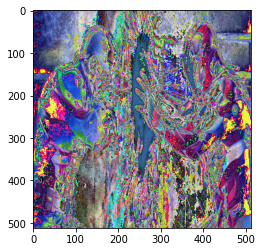

In [118]:
# generated_image = init_generated_img((3, 512, 512))
generated_image = content_image.clone().requires_grad_(True)
plt.imshow(to_pil(generated_image).convert("RGB"))

Epoch: 0, Loss: 9790192640.0


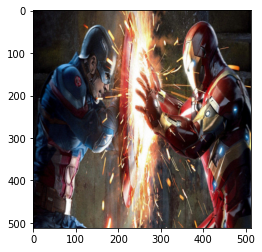

Epoch: 1, Loss: 6061087744.0
Epoch: 2, Loss: 4332077568.0
Epoch: 3, Loss: 3404017408.0
Epoch: 4, Loss: 2856420096.0
Epoch: 5, Loss: 2510675200.0
Epoch: 6, Loss: 2280018944.0
Epoch: 7, Loss: 2117509632.0
Epoch: 8, Loss: 1998402560.0
Epoch: 9, Loss: 1906844416.0
Epoch: 10, Loss: 1833328768.0
Epoch: 11, Loss: 1771743360.0
Epoch: 12, Loss: 1718040448.0
Epoch: 13, Loss: 1669761152.0
Epoch: 14, Loss: 1625071872.0
Epoch: 15, Loss: 1582959872.0
Epoch: 16, Loss: 1542740736.0
Epoch: 17, Loss: 1503918336.0
Epoch: 18, Loss: 1466215296.0
Epoch: 19, Loss: 1429491840.0
Epoch: 20, Loss: 1393741056.0
Epoch: 21, Loss: 1358973056.0
Epoch: 22, Loss: 1325181184.0
Epoch: 23, Loss: 1292375424.0
Epoch: 24, Loss: 1260608640.0
Epoch: 25, Loss: 1229857536.0


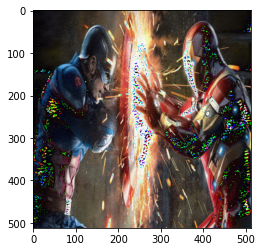

Epoch: 26, Loss: 1200131456.0
Epoch: 27, Loss: 1171432192.0
Epoch: 28, Loss: 1143740160.0
Epoch: 29, Loss: 1117025664.0
Epoch: 30, Loss: 1091254144.0
Epoch: 31, Loss: 1066465600.0
Epoch: 32, Loss: 1042638208.0
Epoch: 33, Loss: 1019716096.0
Epoch: 34, Loss: 997666816.0
Epoch: 35, Loss: 976440256.0
Epoch: 36, Loss: 956020736.0
Epoch: 37, Loss: 936377344.0
Epoch: 38, Loss: 917484224.0
Epoch: 39, Loss: 899333120.0
Epoch: 40, Loss: 881868928.0
Epoch: 41, Loss: 865056448.0
Epoch: 42, Loss: 848860672.0
Epoch: 43, Loss: 833271232.0
Epoch: 44, Loss: 818259840.0
Epoch: 45, Loss: 803779776.0
Epoch: 46, Loss: 789813696.0
Epoch: 47, Loss: 776352640.0
Epoch: 48, Loss: 763351168.0
Epoch: 49, Loss: 750807808.0
Epoch: 50, Loss: 738696896.0


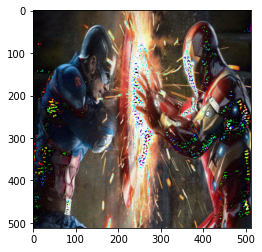

Epoch: 51, Loss: 727012224.0
Epoch: 52, Loss: 715735424.0
Epoch: 53, Loss: 704837568.0
Epoch: 54, Loss: 694289920.0
Epoch: 55, Loss: 684091520.0
Epoch: 56, Loss: 674215616.0
Epoch: 57, Loss: 664660288.0
Epoch: 58, Loss: 655408000.0
Epoch: 59, Loss: 646444608.0
Epoch: 60, Loss: 637753088.0
Epoch: 61, Loss: 629314944.0
Epoch: 62, Loss: 621126784.0
Epoch: 63, Loss: 613182528.0
Epoch: 64, Loss: 605463552.0
Epoch: 65, Loss: 597950016.0
Epoch: 66, Loss: 590648576.0
Epoch: 67, Loss: 583543680.0
Epoch: 68, Loss: 576633472.0
Epoch: 69, Loss: 569910976.0
Epoch: 70, Loss: 563362944.0
Epoch: 71, Loss: 556988352.0
Epoch: 72, Loss: 550773184.0
Epoch: 73, Loss: 544708224.0
Epoch: 74, Loss: 538791936.0
Epoch: 75, Loss: 533021824.0


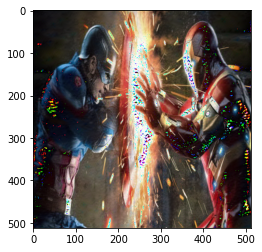

Epoch: 76, Loss: 527392864.0
Epoch: 77, Loss: 521899360.0
Epoch: 78, Loss: 516527840.0
Epoch: 79, Loss: 511292576.0
Epoch: 80, Loss: 506174208.0
Epoch: 81, Loss: 501171520.0
Epoch: 82, Loss: 496292000.0
Epoch: 83, Loss: 491521984.0
Epoch: 84, Loss: 486850688.0
Epoch: 85, Loss: 482277824.0
Epoch: 86, Loss: 477805408.0
Epoch: 87, Loss: 473437664.0
Epoch: 88, Loss: 469164608.0
Epoch: 89, Loss: 464966912.0
Epoch: 90, Loss: 460850688.0
Epoch: 91, Loss: 456819776.0
Epoch: 92, Loss: 452872864.0
Epoch: 93, Loss: 449002848.0
Epoch: 94, Loss: 445214720.0
Epoch: 95, Loss: 441497664.0
Epoch: 96, Loss: 437848832.0
Epoch: 97, Loss: 434266048.0
Epoch: 98, Loss: 430750720.0
Epoch: 99, Loss: 427302880.0
Epoch: 100, Loss: 423921056.0


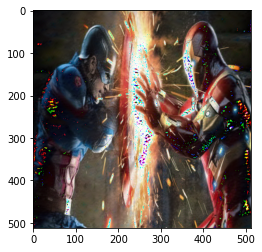

Epoch: 101, Loss: 420600608.0
Epoch: 102, Loss: 417337088.0
Epoch: 103, Loss: 414127968.0
Epoch: 104, Loss: 410973824.0
Epoch: 105, Loss: 407877504.0
Epoch: 106, Loss: 404834368.0
Epoch: 107, Loss: 401846368.0
Epoch: 108, Loss: 398907360.0
Epoch: 109, Loss: 396014816.0
Epoch: 110, Loss: 393170816.0
Epoch: 111, Loss: 390370976.0
Epoch: 112, Loss: 387616160.0
Epoch: 113, Loss: 384906912.0
Epoch: 114, Loss: 382242400.0
Epoch: 115, Loss: 379621056.0
Epoch: 116, Loss: 377042816.0
Epoch: 117, Loss: 374506016.0
Epoch: 118, Loss: 372006432.0
Epoch: 119, Loss: 369543360.0
Epoch: 120, Loss: 367120032.0
Epoch: 121, Loss: 364734016.0
Epoch: 122, Loss: 362379680.0
Epoch: 123, Loss: 360061504.0
Epoch: 124, Loss: 357778176.0
Epoch: 125, Loss: 355530848.0


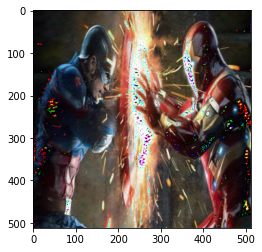

Epoch: 126, Loss: 353312608.0
Epoch: 127, Loss: 351130976.0
Epoch: 128, Loss: 348977856.0
Epoch: 129, Loss: 346857984.0
Epoch: 130, Loss: 344766880.0
Epoch: 131, Loss: 342704512.0
Epoch: 132, Loss: 340670912.0
Epoch: 133, Loss: 338666240.0
Epoch: 134, Loss: 336690336.0
Epoch: 135, Loss: 334740736.0
Epoch: 136, Loss: 332818560.0
Epoch: 137, Loss: 330923328.0
Epoch: 138, Loss: 329052160.0
Epoch: 139, Loss: 327206720.0
Epoch: 140, Loss: 325386432.0
Epoch: 141, Loss: 323583392.0
Epoch: 142, Loss: 321805568.0
Epoch: 143, Loss: 320050624.0
Epoch: 144, Loss: 318316544.0
Epoch: 145, Loss: 316604768.0
Epoch: 146, Loss: 314914720.0
Epoch: 147, Loss: 313245280.0
Epoch: 148, Loss: 311598880.0
Epoch: 149, Loss: 309973344.0
Epoch: 150, Loss: 308365984.0


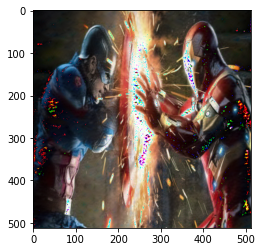

Epoch: 151, Loss: 306778848.0
Epoch: 152, Loss: 305208704.0
Epoch: 153, Loss: 303658432.0
Epoch: 154, Loss: 302126656.0
Epoch: 155, Loss: 300612128.0
Epoch: 156, Loss: 299117760.0
Epoch: 157, Loss: 297639968.0
Epoch: 158, Loss: 296181632.0
Epoch: 159, Loss: 294740704.0
Epoch: 160, Loss: 293315296.0
Epoch: 161, Loss: 291905152.0
Epoch: 162, Loss: 290511584.0
Epoch: 163, Loss: 289136320.0
Epoch: 164, Loss: 287773600.0
Epoch: 165, Loss: 286428256.0
Epoch: 166, Loss: 285097344.0
Epoch: 167, Loss: 283782976.0
Epoch: 168, Loss: 282481600.0
Epoch: 169, Loss: 281194368.0
Epoch: 170, Loss: 279921152.0
Epoch: 171, Loss: 278664448.0
Epoch: 172, Loss: 277420000.0
Epoch: 173, Loss: 276188704.0
Epoch: 174, Loss: 274969856.0
Epoch: 175, Loss: 273763008.0


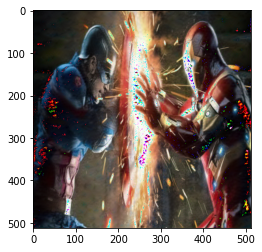

Epoch: 176, Loss: 272570944.0
Epoch: 177, Loss: 271389024.0
Epoch: 178, Loss: 270218912.0
Epoch: 179, Loss: 269060960.0
Epoch: 180, Loss: 267915408.0
Epoch: 181, Loss: 266782480.0
Epoch: 182, Loss: 265660000.0
Epoch: 183, Loss: 264550208.0
Epoch: 184, Loss: 263449824.0
Epoch: 185, Loss: 262360944.0
Epoch: 186, Loss: 261282864.0
Epoch: 187, Loss: 260217136.0
Epoch: 188, Loss: 259159920.0
Epoch: 189, Loss: 258114000.0
Epoch: 190, Loss: 257079536.0
Epoch: 191, Loss: 256052912.0
Epoch: 192, Loss: 255039152.0
Epoch: 193, Loss: 254033776.0
Epoch: 194, Loss: 253037136.0
Epoch: 195, Loss: 252052480.0
Epoch: 196, Loss: 251075744.0
Epoch: 197, Loss: 250109376.0
Epoch: 198, Loss: 249152128.0
Epoch: 199, Loss: 248204080.0
Epoch: 200, Loss: 247264160.0


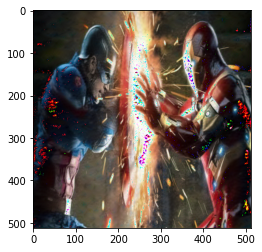

Epoch: 201, Loss: 246332816.0
Epoch: 202, Loss: 245410976.0
Epoch: 203, Loss: 244496160.0
Epoch: 204, Loss: 243590528.0
Epoch: 205, Loss: 242694144.0
Epoch: 206, Loss: 241804896.0
Epoch: 207, Loss: 240925264.0
Epoch: 208, Loss: 240053888.0
Epoch: 209, Loss: 239190176.0
Epoch: 210, Loss: 238332944.0
Epoch: 211, Loss: 237484784.0
Epoch: 212, Loss: 236645392.0
Epoch: 213, Loss: 235811792.0
Epoch: 214, Loss: 234986256.0
Epoch: 215, Loss: 234167776.0
Epoch: 216, Loss: 233357232.0
Epoch: 217, Loss: 232552192.0
Epoch: 218, Loss: 231755376.0
Epoch: 219, Loss: 230965392.0
Epoch: 220, Loss: 230182816.0
Epoch: 221, Loss: 229405216.0
Epoch: 222, Loss: 228636192.0
Epoch: 223, Loss: 227872768.0
Epoch: 224, Loss: 227115760.0
Epoch: 225, Loss: 226365024.0


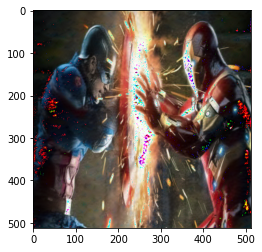

Epoch: 226, Loss: 225620416.0
Epoch: 227, Loss: 224882144.0
Epoch: 228, Loss: 224149968.0
Epoch: 229, Loss: 223423680.0
Epoch: 230, Loss: 222704080.0
Epoch: 231, Loss: 221989744.0
Epoch: 232, Loss: 221281136.0
Epoch: 233, Loss: 220579392.0
Epoch: 234, Loss: 219882368.0
Epoch: 235, Loss: 219191584.0
Epoch: 236, Loss: 218505952.0
Epoch: 237, Loss: 217825456.0
Epoch: 238, Loss: 217150944.0
Epoch: 239, Loss: 216482272.0
Epoch: 240, Loss: 215818800.0
Epoch: 241, Loss: 215160224.0
Epoch: 242, Loss: 214505952.0
Epoch: 243, Loss: 213856784.0
Epoch: 244, Loss: 213212864.0
Epoch: 245, Loss: 212573248.0
Epoch: 246, Loss: 211938816.0
Epoch: 247, Loss: 211308688.0
Epoch: 248, Loss: 210683616.0
Epoch: 249, Loss: 210062752.0
Epoch: 250, Loss: 209447424.0


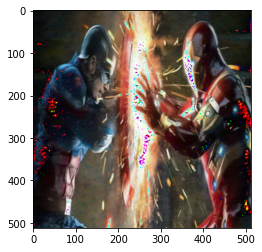

Epoch: 251, Loss: 208835808.0
Epoch: 252, Loss: 208229584.0
Epoch: 253, Loss: 207627088.0
Epoch: 254, Loss: 207030384.0
Epoch: 255, Loss: 206437440.0
Epoch: 256, Loss: 205848240.0
Epoch: 257, Loss: 205264032.0
Epoch: 258, Loss: 204683760.0
Epoch: 259, Loss: 204107776.0
Epoch: 260, Loss: 203536304.0
Epoch: 261, Loss: 202969536.0
Epoch: 262, Loss: 202406944.0
Epoch: 263, Loss: 201847408.0
Epoch: 264, Loss: 201291968.0
Epoch: 265, Loss: 200739920.0
Epoch: 266, Loss: 200192384.0
Epoch: 267, Loss: 199648784.0
Epoch: 268, Loss: 199109072.0
Epoch: 269, Loss: 198572528.0
Epoch: 270, Loss: 198040032.0
Epoch: 271, Loss: 197510784.0
Epoch: 272, Loss: 196986608.0
Epoch: 273, Loss: 196465952.0
Epoch: 274, Loss: 195948768.0
Epoch: 275, Loss: 195435904.0


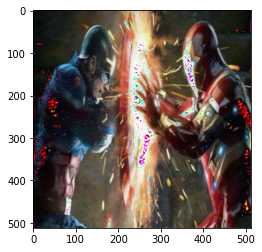

Epoch: 276, Loss: 194925952.0
Epoch: 277, Loss: 194420448.0
Epoch: 278, Loss: 193917472.0
Epoch: 279, Loss: 193417840.0
Epoch: 280, Loss: 192922640.0
Epoch: 281, Loss: 192430816.0
Epoch: 282, Loss: 191942192.0
Epoch: 283, Loss: 191455904.0
Epoch: 284, Loss: 190973744.0
Epoch: 285, Loss: 190494576.0
Epoch: 286, Loss: 190018496.0
Epoch: 287, Loss: 189545872.0
Epoch: 288, Loss: 189076960.0
Epoch: 289, Loss: 188610304.0
Epoch: 290, Loss: 188146976.0
Epoch: 291, Loss: 187687184.0
Epoch: 292, Loss: 187230448.0
Epoch: 293, Loss: 186776832.0
Epoch: 294, Loss: 186326240.0
Epoch: 295, Loss: 185878544.0
Epoch: 296, Loss: 185433184.0
Epoch: 297, Loss: 184991696.0
Epoch: 298, Loss: 184553088.0
Epoch: 299, Loss: 184117104.0
Epoch: 300, Loss: 183684000.0


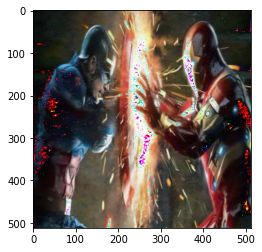

Epoch: 301, Loss: 183254080.0
Epoch: 302, Loss: 182826624.0
Epoch: 303, Loss: 182401680.0
Epoch: 304, Loss: 181979824.0
Epoch: 305, Loss: 181560800.0
Epoch: 306, Loss: 181143968.0
Epoch: 307, Loss: 180729696.0
Epoch: 308, Loss: 180318096.0
Epoch: 309, Loss: 179909152.0
Epoch: 310, Loss: 179502768.0
Epoch: 311, Loss: 179098032.0
Epoch: 312, Loss: 178696496.0
Epoch: 313, Loss: 178297040.0
Epoch: 314, Loss: 177900368.0
Epoch: 315, Loss: 177506352.0
Epoch: 316, Loss: 177114192.0
Epoch: 317, Loss: 176723744.0
Epoch: 318, Loss: 176336416.0
Epoch: 319, Loss: 175951520.0
Epoch: 320, Loss: 175569072.0
Epoch: 321, Loss: 175188400.0
Epoch: 322, Loss: 174810064.0
Epoch: 323, Loss: 174433264.0
Epoch: 324, Loss: 174059616.0
Epoch: 325, Loss: 173687440.0


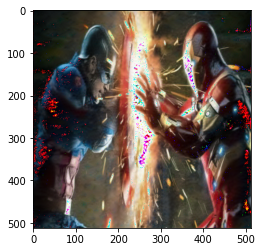

Epoch: 326, Loss: 173317744.0
Epoch: 327, Loss: 172949680.0
Epoch: 328, Loss: 172583920.0
Epoch: 329, Loss: 172219920.0
Epoch: 330, Loss: 171857712.0
Epoch: 331, Loss: 171498080.0
Epoch: 332, Loss: 171140112.0
Epoch: 333, Loss: 170783984.0
Epoch: 334, Loss: 170430192.0
Epoch: 335, Loss: 170077808.0
Epoch: 336, Loss: 169727792.0
Epoch: 337, Loss: 169379440.0
Epoch: 338, Loss: 169033232.0
Epoch: 339, Loss: 168689424.0
Epoch: 340, Loss: 168347440.0
Epoch: 341, Loss: 168007008.0
Epoch: 342, Loss: 167668544.0
Epoch: 343, Loss: 167332496.0
Epoch: 344, Loss: 166997648.0
Epoch: 345, Loss: 166665200.0
Epoch: 346, Loss: 166333856.0
Epoch: 347, Loss: 166004544.0
Epoch: 348, Loss: 165677184.0
Epoch: 349, Loss: 165351152.0


KeyboardInterrupt: 

In [119]:
# generated_image = generated_image.requires_grad_(True)
optimiser = optim.Adam([generated_image], lr=0.01)
num_epochs = 10000

for epoch in range(num_epochs):
    layer_activations = construct_layer_activations(
        extraction_layers,
        generated_image
    )
     
    loss = style_transfer_cost_function(layer_activations)
    print(f"Epoch: {epoch}, Loss: {loss}")
     
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    if epoch % 25 == 0:
        plt.imshow(to_pil(inv_normalize(generated_image)).convert("RGB"))
        plt.show()

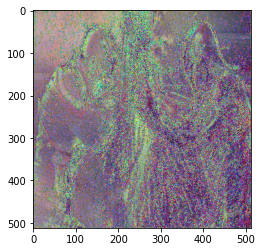

In [278]:
plt.imshow(to_pil(generated_image).convert("RGB"))

In [ ]:
save_image(generated_image, "iron_man_generated.png")